# **Generative AI**
 A generative model learns a probability distribution of the data set and then we can then sample from the distribution to create new instances of data.

# **Imports**

In [3]:
import torch
from torch import nn
from torch.nn import functional as F

import numpy as np
import torchvision
import math
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.utils as utils

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets, transforms

from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

C:\Users\pande\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Setting up CUDA**

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **Creating the time embeddings**

In [5]:
def get_time_embedding(timestep):
    # Shape: (40, 2)
    freqs = torch.pow(10000, -torch.arange(start=0, end=40, dtype=torch.float32) / 80)
    # Shape: (1, 40)
    x = torch.tensor(timestep, dtype=torch.float32)[:, None] * freqs[None]
    # Shape: (1, 40 * 2)
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)

In [6]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, 4 * n_embd)

    def forward(self, x):
        # x: (1, 80)

        # (1, 80) -> (1, 320)
        x = self.linear_1(x)

        # (1, 320) -> (1, 320)
        x = F.silu(x)

        # (1, 320) -> (1, 320)
        x = self.linear_2(x)

        return x

# **Defining the Residual Connections**

In [7]:
class UNET_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_time = 320):
        super().__init__()
        self.groupnorm_feature = nn.GroupNorm(16, in_channels)
        self.conv_feature = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.linear_time = nn.Linear(n_time, out_channels)

        self.groupnorm_merged = nn.GroupNorm(16, out_channels)
        self.conv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, feature, time):
        # feature: (Batch_Size, In_Channels, Height, Width)
        # time: (1, 320)

        residue = feature

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        feature = self.groupnorm_feature(feature)

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        feature = F.silu(feature)

        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        feature = self.conv_feature(feature)

        # (1, 320) -> (1, 320)
        time = F.silu(time)

        # (1, 320) -> (1, Out_Channels)
        time = self.linear_time(time)

        # Add width and height dimension to time.
        # (Batch_Size, Out_Channels, Height, Width) + (1, Out_Channels, 1, 1) -> (Batch_Size, Out_Channels, Height, Width)
        merged = feature + time.unsqueeze(-1).unsqueeze(-1)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = self.groupnorm_merged(merged)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = F.silu(merged)

        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        merged = self.conv_merged(merged)

        # (Batch_Size, Out_Channels, Height, Width) + (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        return merged + self.residual_layer(residue)

# **Creating the attention layers**

In [8]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads
        self.d_head = d_embed // n_heads

    def forward(self, x):
        # x: # (Batch_Size, Seq_Len, Dim)

        # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape

        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape

        # (Batch_Size, Seq_Len, H, Dim / H)
        interim_shape = (batch_size, sequence_length, self.n_heads, self.d_head)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k, v = self.in_proj(x).chunk(3, dim=-1)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len, Dim) @ (Batch_Size, H, Dim, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)

        # Divide by d_k (Dim / H).
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head)

        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = F.softmax(weight, dim=-1)

        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v

        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2)

        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.out_proj(output)

        # (Batch_Size, Seq_Len, Dim)
        return output

In [9]:
class UNET_AttentionBlock(nn.Module):
    def __init__(self, n_head: int, n_embd: int):
        super().__init__()
        channels = n_head * n_embd

        self.groupnorm = nn.GroupNorm(16, channels, eps=1e-6)
        self.conv_input = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

        self.layernorm_1 = nn.LayerNorm(channels)
        self.attention_1 = SelfAttention(n_head, channels, in_proj_bias=False)
        self.layernorm_3 = nn.LayerNorm(channels)
        self.linear_geglu_1  = nn.Linear(channels, 4 * channels * 2)
        self.linear_geglu_2 = nn.Linear(4 * channels, channels)

        self.conv_output = nn.Conv2d(channels, channels, kernel_size=1, padding=0)

    def forward(self, x):
        # x: (Batch_Size, Features, Height, Width)

        residue_long = x

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.groupnorm(x)

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        x = self.conv_input(x)

        n, c, h, w = x.shape

        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * Width)
        x = x.view((n, c, h * w))

        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features)
        x = x.transpose(-1, -2)

        # Normalization + Self-Attention with skip connection

        # (Batch_Size, Height * Width, Features)
        residue_short = x

        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.layernorm_1(x)

        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.attention_1(x)

        # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short

        # Normalization + FFN with GeGLU and skip connection
        residue_short = x
        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x = self.layernorm_3(x)

        # Use of geglu taken from Stable Diffusion github
        # (Batch_Size, Height * Width, Features) -> two tensors of shape (Batch_Size, Height * Width, Features * 4)
        x, gate = self.linear_geglu_1(x).chunk(2, dim=-1)

        # Element-wise product: (Batch_Size, Height * Width, Features * 4) * (Batch_Size, Height * Width, Features * 4) -> (Batch_Size, Height * Width, Features * 4)
        x = x * F.gelu(gate)

        # (Batch_Size, Height * Width, Features * 4) -> (Batch_Size, Height * Width, Features)
        x = self.linear_geglu_2(x)

        # (Batch_Size, Height * Width, Features) + (Batch_Size, Height * Width, Features) -> (Batch_Size, Height * Width, Features)
        x += residue_short

        # (Batch_Size, Height * Width, Features) -> (Batch_Size, Features, Height * Width)
        x = x.transpose(-1, -2)

        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        x = x.view((n, c, h, w))

        # Final skip connection between initial input and output of the block
        # (Batch_Size, Features, Height, Width) + (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height, Width)
        return self.conv_output(x) + residue_long

In [10]:
class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        # (Batch_Size, Features, Height, Width) -> (Batch_Size, Features, Height * 2, Width * 2)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)


In [11]:
class SwitchSequential(nn.Sequential):
    def forward(self, x, time):
        for layer in self:
            if isinstance(layer, UNET_AttentionBlock):
                x = layer(x)
            elif isinstance(layer, UNET_ResidualBlock):
                x = layer(x, time)
            else:
                x = layer(x)
        return x

# **Forward Process -- Noise Scheduler**

In [12]:
class DDPMSampler:

    def __init__(self, num_training_steps=1000, beta_start: float = 0.00085, beta_end: float = 0.0120):
        # For the naming conventions, refer to the DDPM paper
        self.betas = torch.linspace(beta_start , beta_end, num_training_steps, dtype=torch.float32)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.one = torch.tensor(1.0)
        generator = torch.Generator(device=device)
        generator.seed()
        self.generator = generator
        self.num_train_timesteps = num_training_steps
        self.timesteps = torch.from_numpy(np.arange(0, num_training_steps)[::-1].copy())

    def set_inference_timesteps(self, num_inference_steps=50):
        self.num_inference_steps = num_inference_steps
        step_ratio = self.num_train_timesteps // self.num_inference_steps
        timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
        self.timesteps = torch.from_numpy(timesteps)

    def _get_previous_timestep(self, timestep: int) -> int:
        prev_t = timestep - self.num_train_timesteps // self.num_inference_steps
        return prev_t

    def _get_variance(self, timestep: int) -> torch.Tensor:
        prev_t = self._get_previous_timestep(timestep)

        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        current_beta_t = 1 - alpha_prod_t / alpha_prod_t_prev
        variance = (1 - alpha_prod_t_prev) / (1 - alpha_prod_t) * current_beta_t

        # we always take the log of variance, so clamp it to ensure it's not 0
        variance = torch.clamp(variance, min=1e-20)

        return variance

    def step(self, timestep: int, reshaped_image: torch.Tensor, model_output: torch.Tensor):
        t = timestep
        prev_t = self._get_previous_timestep(t)

        # 1. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[t]
        alpha_prod_t_prev = self.alphas_cumprod[prev_t] if prev_t >= 0 else self.one
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev
        current_alpha_t = alpha_prod_t / alpha_prod_t_prev
        current_beta_t = 1 - current_alpha_t

        # 2. compute predicted original sample from predicted noise also called
        pred_original_sample = (reshaped_image - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)

        # 3. Compute coefficients for pred_original_sample x_0 and current sample x_t
        pred_original_sample_coeff = (alpha_prod_t_prev ** (0.5) * current_beta_t) / beta_prod_t
        current_sample_coeff = current_alpha_t ** (0.5) * beta_prod_t_prev / beta_prod_t

        # 4. Compute predicted previous sample µ_t
        pred_prev_sample = pred_original_sample_coeff * pred_original_sample + current_sample_coeff * reshaped_image

        # 5. Add noise
        variance = 0
        if t > 0:
            device = model_output.device
            noise = torch.randn(model_output.shape, device=device, dtype=model_output.dtype)
            # Computing the variance
            variance = (self._get_variance(t) ** 0.5) * noise

        # sample from N(mu, sigma) = X can be obtained by X = mu + sigma * N(0, 1)
        # the variable "variance" is already multiplied by the noise N(0, 1)
        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

    def add_noise(
        self,
        original_samples: torch.FloatTensor,
        timesteps: torch.IntTensor,
    ) -> torch.FloatTensor:
        alphas_cumprod = self.alphas_cumprod.to(device=original_samples.device, dtype=original_samples.dtype)
        timesteps = timesteps.to(original_samples.device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        noise = torch.randn(original_samples.shape, generator=self.generator, device=original_samples.device, dtype=original_samples.dtype)
        noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        return noisy_samples, noise

# **Backward Process -- U-Net**

In [13]:
class UNET(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoders = nn.ModuleList([

            # (Batch_Size,1 , Height , Width) -> (Batch_Size, 64, Height , Width )
            SwitchSequential(nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)),

            # (Batch_Size, 64, Height / 8, Width / 8) -> # (Batch_Size, 64, Height / 8, Width / 8) -> (Batch_Size, 64, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(64, 64), UNET_AttentionBlock(4, 16)),

            # (Batch_Size, 64, Height / 8, Width / 8) -> # (Batch_Size, 64, Height / 8, Width / 8) -> (Batch_Size, 64, Height / 8, Width / 8)
            SwitchSequential(UNET_ResidualBlock(64, 64), UNET_AttentionBlock(4, 16)),

            # (Batch_Size, 64, Height , Width) -> (Batch_Size, 128, Height / 2, Width / 2)
            SwitchSequential(nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)),

            # (Batch_Size, 64, Height / 16, Width / 16) -> (Batch_Size, 128, Height / 16, Width / 16) -> (Batch_Size, 128, Height / 16, Width / 16)
            SwitchSequential(UNET_ResidualBlock(64, 128), UNET_AttentionBlock(4, 32)),

            # (Batch_Size, 128, Height / 2, Width / 2) -> (Batch_Size, 128, Height / 2, Width / 2) -> (Batch_Size, 128, Height / 2, Width / 2)
            SwitchSequential(UNET_ResidualBlock(128, 128), UNET_AttentionBlock(4, 32)),

            # (Batch_Size, 128, Height / 2, Width / 2) -> (Batch_Size, 256, Height / 4, Width / 4)
            SwitchSequential(nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)),

            # (Batch_Size, 128, Height / 64, Width / 64) -> (Batch_Size, 128, Height / 64, Width / 64)
            SwitchSequential(UNET_ResidualBlock(128, 128)),

            # (Batch_Size, 128, Height / 64, Width / 64) -> (Batch_Size, 128, Height / 64, Width / 64)
            SwitchSequential(UNET_ResidualBlock(128, 128)),
        ])

        self.bottleneck = SwitchSequential(
            # (Batch_Size, 256, Height / 4, Width / 4) -> (Batch_Size, 256, Height / 4, Width / 4)
            UNET_ResidualBlock(128, 128),

            # (Batch_Size, 256, Height / 4, Width / 4) -> (Batch_Size, 256, Height / 4, Width / 4)
            UNET_AttentionBlock(4, 32),

            # (Batch_Size, 256, Height / 4, Width / 4) -> (Batch_Size, 256, Height / 4, Width / 4)
            UNET_ResidualBlock(128, 128),
        )

        self.decoders = nn.ModuleList([

            # (Batch_Size, 256, Height / 64, Width / 64) -> (Batch_Size, 128, Height / 64, Width / 64)
            SwitchSequential(UNET_ResidualBlock(256, 128)),

            # (Batch_Size, 256, Height / 64, Width / 64) -> (Batch_Size, 128, Height / 64, Width / 64)
            SwitchSequential(UNET_ResidualBlock(256, 128)),

            # (Batch_Size, 256, Height / 64, Width / 64) -> (Batch_Size, 128, Height / 64, Width / 64) -> (Batch_Size, 128, Height / 32, Width / 32)
            SwitchSequential(UNET_ResidualBlock(256, 128), Upsample(128)),

            # (Batch_Size, 256, Height / 32, Width / 32) -> (Batch_Size, 128, Height / 32, Width / 32) -> (Batch_Size, 128, Height / 32, Width / 32)
            SwitchSequential(UNET_ResidualBlock(256, 128), UNET_AttentionBlock(4, 32)),

            # (Batch_Size, 256, Height / 32, Width / 32) -> (Batch_Size, 128, Height / 32, Width / 32) -> (Batch_Size, 128, Height / 32, Width / 32)
            SwitchSequential(UNET_ResidualBlock(256, 128), UNET_AttentionBlock(4, 32)),

            # (Batch_Size, 192, Height / 32, Width / 32) -> (Batch_Size, 128, Height / 32, Width / 32) -> (Batch_Size, 128, Height / 32, Width / 32) -> (Batch_Size, 128, Height / 16, Width / 16)
            SwitchSequential(UNET_ResidualBlock(192, 128), UNET_AttentionBlock(4, 32), Upsample(128)),

            # (Batch_Size, 192, Height / 16, Width / 16) -> (Batch_Size, 64, Height / 16, Width / 16) -> (Batch_Size, 64, Height / 16, Width / 16)
            SwitchSequential(UNET_ResidualBlock(192, 64), UNET_AttentionBlock(4, 16)),

            # (Batch_Size, 128, Height / 16, Width / 16) -> (Batch_Size, 64, Height / 16, Width / 16) -> (Batch_Size, 64, Height / 16, Width / 16)
            SwitchSequential(UNET_ResidualBlock(128, 64), UNET_AttentionBlock(4, 16)),

            # (Batch_Size, 128, Height / 16, Width / 16) -> (Batch_Size, 64, Height / 16, Width / 16) -> (Batch_Size, 64, Height / 16, Width / 16)
            SwitchSequential(UNET_ResidualBlock(128, 64), UNET_AttentionBlock(4, 16)),
        ])

    def forward(self, x, time):
        # x: (Batch_Size, 1, Height , Width)
        # time: (1, 640)

        skip_connections = []
        for layers in self.encoders:
            x = layers(x, time)
            skip_connections.append(x)
        x = self.bottleneck(x, time)

        for layers in self.decoders:
            x = torch.cat((x, skip_connections.pop()), dim=1)
            x = layers(x, time)

        return x

In [14]:
class UNET_OutputLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(16, in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # x: (Batch_Size, 64, Height , Width )

        # (Batch_Size, 64, Height, Width ) -> (Batch_Size, 64, Height , Width )
        x = self.groupnorm(x)

        # (Batch_Size, 64, Height, Width ) -> (Batch_Size, 64, Height , Width )
        x = F.silu(x)

        # (Batch_Size, 64, Height, Width ) -> (Batch_Size, 1, Height , Width )
        x = self.conv(x)

        # (Batch_Size, 1, Height , Width)
        return x


In [15]:
class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embedding = TimeEmbedding(80)
        self.unet = UNET()
        self.final = UNET_OutputLayer(64, 1)

    def forward(self, x, time):
        # x: (Batch_Size, 1, Height , Width )
        # time: (1, 80)

        # (1, 80) -> (1, 320)
        time = self.time_embedding(time)

        # (Batch, 1, Height , Width ) -> (Batch, 40, Height, Width )
        output = self.unet(x, time)

        # (Batch, 40, Height , Width ) -> (Batch, 1, Height , Width )
        output = self.final(output)

        # (Batch, 1, Height , Width)
        return output

# **Importing Dataset and creating dataloader**

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading the MNIST training and testing datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Creating DataLoaders for training and testing
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5111862.26it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134963.67it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1276640.11it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2757349.66it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# **Plotting images of the training data**

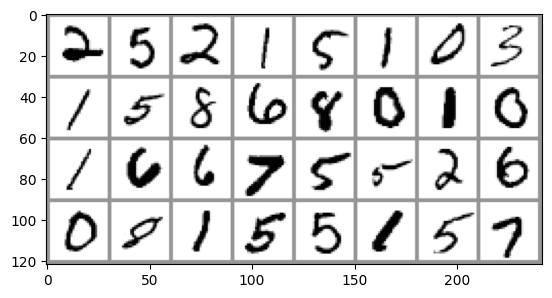

In [ ]:
x, _ = next(iter(train_loader))
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')

# **Creating a model instance**

In [16]:
my_sampler = DDPMSampler()
diffusion_model = Diffusion().to(device)
optim = torch.optim.AdamW(diffusion_model.parameters())

# **Training Function**

In [ ]:
def train_unet(model,sampler, train_loader, optimizer):
    losses = []
    model.train()
    for i, x in enumerate(train_loader):
        if(i % 50 == 0) :
            print(i)
        x = x[0].to(device)  # GPU
        t = torch.randint(0, 1000, (32,)).long()
        time_embeddings = get_time_embedding(t).to(device)
        noisy_x, noise_added = sampler.add_noise(x, t)
        noisy_x = noisy_x.to(device)
        noise_added = noise_added.to(device)
        noise_pred = model(x = noisy_x, time = time_embeddings)
        loss = nn.MSELoss()(noise_added, noise_pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

# **Training Loop**

In [ ]:
epochs = 10
train_losses = []

best_dict = None

optim = torch.optim.AdamW(diffusion_model.parameters())
for epoch in range(epochs):

    print('='*5 + f"Epoch {epoch + 1}" + '='*5)
    train_loss = train_unet(model= diffusion_model,sampler = my_sampler, train_loader= train_loader, optimizer= optim)
    best_dict = diffusion_model.state_dict()
    torch.save(best_dict, "diffusion.tar")

    train_losses.append(train_loss)
    print(f"Epoch {epoch + 1} - Train Loss {train_loss: .4f}")

=====Epoch 1=====
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
Epoch 1 - Train Loss  0.0238
=====Epoch 2=====
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
Epoch 2 - Train Loss  0.0235
=====Epoch 3=====
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
Epoch 3 - Train Loss  0.0235
=====Epoch 4=====
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
Epoch 4 - Train Loss  0.0235
=====Epoch 5=====
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450

# **Loading the Model**

In [ ]:
checkpoint = torch.load("diffusion.tar")
diffusion_model.load_state_dict(checkpoint)

<All keys matched successfully>

# **Function to Generate Images**

In [20]:
def generate(
    diffusion_model,
    n_inference_steps=50,
):
    with torch.no_grad():

        sampler = DDPMSampler()
        sampler.set_inference_timesteps(n_inference_steps)

        image_shape = (1, 1, 28, 28)
        image = torch.randn(image_shape, device=device)

        diffusion_model.to(device)

        timesteps = sampler.timesteps
        for i, timestep in enumerate(timesteps):
            # (1, 80)
            time_embedding = get_time_embedding(torch.tensor(timestep).view(1,)).to(device)

            # (Batch_Size, 1, Height, Width)
            model_input = image

            # model_output is the predicted noise
            # (Batch_Size, 1, Height, Width) -> (Batch_Size, 1, Height, Width)
            model_output = diffusion_model(model_input, time_embedding)

            # (Batch_Size, 1, Height, Width) -> (Batch_Size, 1, Height, Width)
            image = sampler.step(timestep, image, model_output)

        # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Height, Width, Channel)
        image = image.permute(0, 2, 3, 1)
        image = image.detach().cpu().clip(0, 1)
        return image[0]

# **Image Generation**

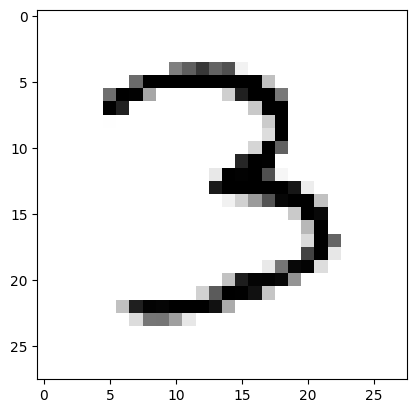

In [31]:
image = generate(diffusion_model)
plt.imshow(image, cmap = 'Greys')

# **Visualize the DDPM noising process for different timesteps**

X shape torch.Size([8, 1, 28, 28])


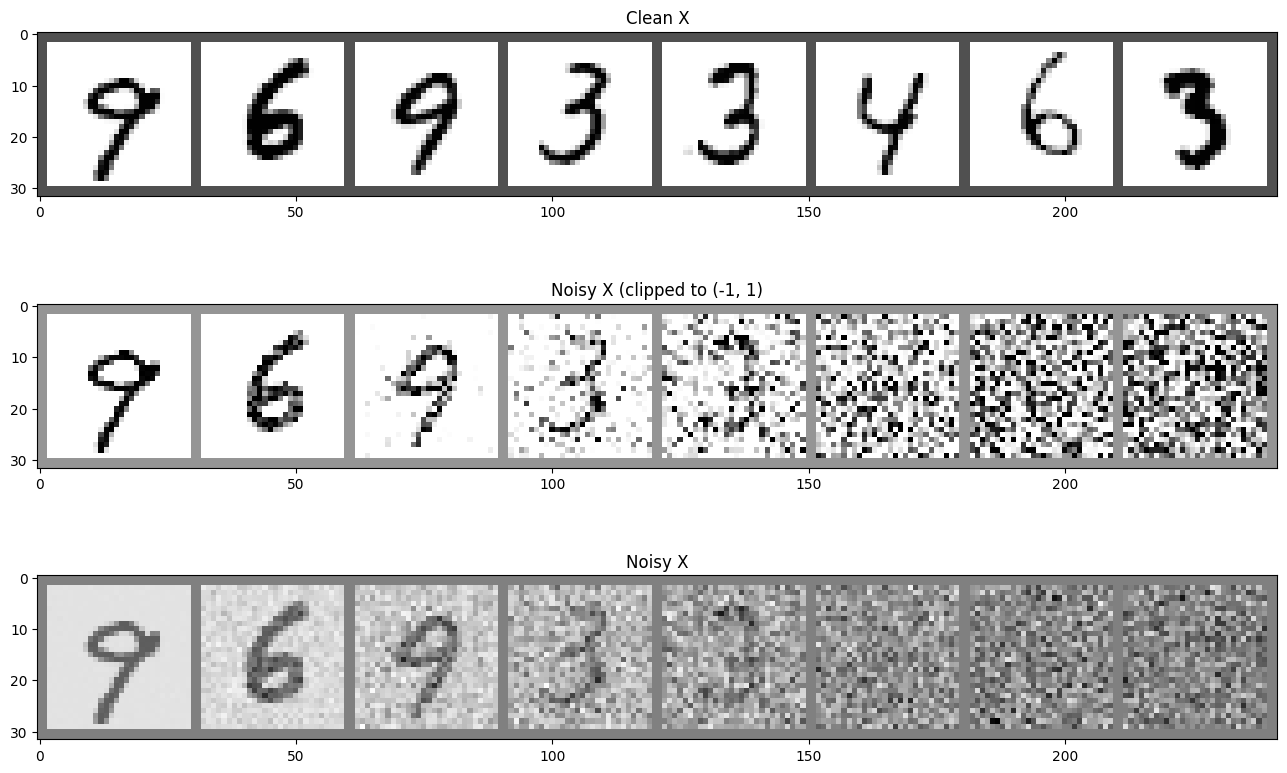

In [ ]:
# Noise a batch of images to view the effect
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_loader))
xb = xb.to(device)[:8]
xb = xb * 2. - 1. # Map to (-1, 1)
print('X shape', xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap='Greys')
axs[0].set_title('Clean X')

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_xb, noise = my_sampler.add_noise(xb, timesteps)
# print('Noisy X shape', noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),  cmap='Greys')
axs[1].set_title('Noisy X (clipped to (-1, 1)')
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(),  cmap='Greys')
axs[2].set_title('Noisy X');